In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
os.chdir(motionbert_root)

### Load h36m dataset

In [2]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [3]:
print(h36m_3d_world.keys())
print(h36m_3d_world['S5'].keys())
print(h36m_3d_world['S5']['Waiting 1'].keys())
print(h36m_3d_world['S5']['Waiting 1']['positions'].shape)

dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])
dict_keys(['Waiting 1', 'Sitting', 'Waiting 2', 'Smoking', 'WalkTogether 1', 'Discussion 2', 'Greeting 1', 'Directions 2', 'Phoning', 'Phoning 1', 'Smoking 1', 'Greeting 2', 'WalkTogether', 'Sitting 1', 'SittingDown', 'SittingDown 1', 'Discussion 3', 'Directions 1', 'Purchases', 'Walking 1', 'WalkDog 1', 'Walking', 'Eating', 'Photo 2', 'Posing', 'Posing 1', 'WalkDog', 'Photo', 'Purchases 1', 'Eating 1'])
dict_keys(['positions', 'cameras'])
(4517, 17, 3)


### Get bbox information of h36m and save it as pkl

In [4]:
# subject = 'S5'
# action = 'Waiting 1'
# camera_id = '54138969'
dict_save_path = '/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/bbox_info_all_subject.pkl'
if os.path.exists(dict_save_path):
    data_dict = readpkl(dict_save_path)
else:
    data_dict = {}
    for subject in h36m_3d_world.keys():
        data_dict[subject] = {}
        print(subject)
        save_video = False
        save_fig = True
        fig = plt.figure(0)
        fig.clear()
        #ax = axes_3d(fig, loc=121)
        ax2 = axes_2d(fig, loc=111, W=1000, H=1000)

        max_left_list = []
        max_right_list = []
        max_top_list = []
        max_bottom_list = []
        mean_center_list = []
        for action in tqdm(h36m_3d_world[subject].keys()):
            data_dict[subject][action] = {}
            pose3d_list = h36m_3d_world[subject][action]['positions']
            cam_info = h36m_3d_world[subject][action]['cameras']
            cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
            for camera_id in cam_param.keys():
                data_dict[subject][action][camera_id] = {}
                #print(subject, action, camera_id)
                calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
                R = cam_param[camera_id]['ext']['R']
                t = np.array(cam_param[camera_id]['ext']['t'])/1000
                camera_param = {
                    'intrinsic': calibration_matrix,
                    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
                }
                fx = camera_param['intrinsic'][0, 0]  
                fy = camera_param['intrinsic'][1, 1]  
                cx = camera_param['intrinsic'][0, 2]  
                cy = camera_param['intrinsic'][1, 2] 

                #frame_num = 0
                top_left_list = []
                bottom_right_list = []
                center_list = []
                if save_video:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    video_path = os.path.join(save_folder, f'check_bbox_{subject}_{action}_{camera_id}.mp4')
                    if os.path.exists(video_path): continue
                    videowriter = imageio.get_writer(video_path, fps=30)
                for frame_num in range(0, len(pose3d_list)):
                    world_3d = np.array(pose3d_list[frame_num])
                    trans = np.zeros(3)
                    rot = np.eye(3) # Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
                    modified = world_3d.copy()
                    if trans is not None:
                        modified -= np.array([modified[0][0], modified[0][1], 0])
                        modified += np.array([trans[0], trans[1], 0])
                    if rot is not None:
                        modified = rotate_torso_by_R(modified, rot)
                    world_3d = modified

                    # world to camera
                    pos = copy.deepcopy(world_3d)
                    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
                    cam_3d_hat = get_rootrel_pose(cam_3d)

                    # camera to image
                    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                    bbox = get_bbox_from_pose2d(img_2d)

                    #clear_axes(ax2)
                    #draw_3d_pose(ax, world_3d)
                    #draw_2d_pose(ax2, img_2d)
                    #draw_bbox(ax2, bbox)
                    top_left_list.append(bbox[:2])
                    bottom_right_list.append(bbox[2:])
                    center_list.append((np.array(bbox[:2]) + np.array(bbox[2:]))/2)
                    # ax2.plot(bbox[0], bbox[1], 'kx')
                    # ax2.plot(bbox[2], bbox[3], 'kx')
                    # ax2.plot((bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2, 'kx')
                    if save_video:
                        canvas = FigureCanvas(fig)
                        canvas.draw()
                        image_from_plot = np.array(canvas.renderer._renderer)
                        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                        videowriter.append_data(image_from_plot)

                clear_axes(ax2)
                top_left_list = np.array(top_left_list)
                bottom_right_list = np.array(bottom_right_list)
                center_list = np.array(center_list)
                draw_trajectory(ax2, top_left_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, bottom_right_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, center_list, -1, recent=0, dim='2d')

                max_left = np.min(top_left_list[:, 0])
                max_top = np.min(top_left_list[:, 1])
                max_right = np.max(bottom_right_list[:, 0])
                max_bottom = np.max(bottom_right_list[:, 1])
                max_left_list.append(max_left)
                max_right_list.append(max_right)
                max_top_list.append(max_top)
                max_bottom_list.append(max_bottom)
                mean_center_list.append(np.mean(center_list, axis=0))
                ax2.plot(max_left, max_top, 'ro')
                ax2.plot(max_right, max_bottom, 'bx')
                draw_bbox(ax2, [max_left, max_top, max_right, max_bottom])

                data_dict[subject][action][camera_id]['top_left_list'] = top_left_list
                data_dict[subject][action][camera_id]['bottom_right_list'] = bottom_right_list
                data_dict[subject][action][camera_id]['center_list'] = center_list
                data_dict[subject][action][camera_id]['max_bbox'] = np.array([max_left, max_top, max_right, max_bottom]) # x1, y1, x2, y2
                

                if save_video:
                    canvas = FigureCanvas(fig)
                    canvas.draw()
                    image_from_plot = np.array(canvas.renderer._renderer)
                    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                    videowriter.append_data(image_from_plot)
                    videowriter.close()
                #else:
                #    plt.show()
                if save_fig:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    fig_path = os.path.join(save_folder, f'check_bbox_area_{subject}_{action}_{camera_id}.png')
                    if os.path.exists(fig_path): continue
                    fig.savefig(fig_path)

                #break
            #break
        max_left_list = np.array(max_left_list)
        max_right_list = np.array(max_right_list)
        max_top_list = np.array(max_top_list)
        max_bottom_list = np.array(max_bottom_list)
        mean_center_list = np.array(mean_center_list)
        data_dict[subject]['max_left_list'] = max_left_list
        data_dict[subject]['max_right_list'] = max_right_list
        data_dict[subject]['max_top_list'] = max_top_list
        data_dict[subject]['max_bottom_list'] = max_bottom_list
        data_dict[subject]['mean_center_list'] = mean_center_list

        fig = plt.figure(1)
        fig.clear()
        ax = fig.add_subplot(111)
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_xlim(0, 1000)
        ax.set_ylim(1000, 0)
        ax.legend()
        plt.suptitle(f'bbox distribution of {subject}')
        plt.savefig(f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}/bbox_distribution.png')

    savepkl(data_dict, dict_save_path)

### Visualize bbox distribution of one subject

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


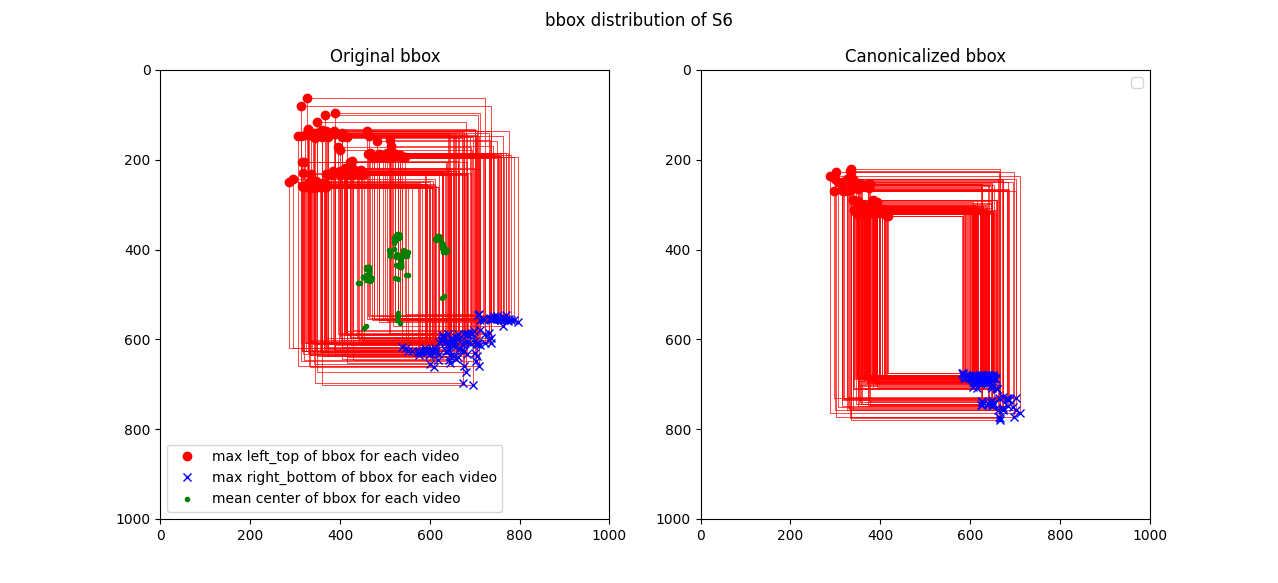

In [95]:
subject = 'S6'

max_left_list = data_dict[subject]['max_left_list']
max_right_list = data_dict[subject]['max_right_list']
max_top_list = data_dict[subject]['max_top_list']
max_bottom_list = data_dict[subject]['max_bottom_list']
mean_center_list = data_dict[subject]['mean_center_list']

fig = plt.figure(1)
fig.clear()
ax = fig.add_subplot(121)

ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
for i in range(len(max_left_list)):
    draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
ax.set_xlim(0, 1000)
ax.set_ylim(1000, 0)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Original bbox')

ax_cano = fig.add_subplot(122)
for i in range(len(max_left_list)):
    center_x = (max_left_list[i] + max_right_list[i])/2
    center_y = (max_top_list[i] + max_bottom_list[i])/2
    max_left_canonical = max_left_list[i]-center_x+500
    max_right_canonical = max_right_list[i]-center_x+500
    max_top_canonical = max_top_list[i]-center_y+500
    max_bottom_canonical = max_bottom_list[i]-center_y+500
    ax_cano.plot(max_left_canonical, max_top_canonical, 'ro')
    ax_cano.plot(max_right_canonical, max_bottom_canonical, 'bx')
    draw_bbox(ax_cano, [max_left_canonical, max_top_canonical, max_right_canonical, max_bottom_canonical], color="red", linewidth=0.5)
ax_cano.set_xlim(0, 1000)
ax_cano.set_ylim(1000, 0)
ax_cano.set_aspect('equal')
ax_cano.legend()
ax_cano.set_title('Canonicalized bbox')

plt.suptitle(f'bbox distribution of {subject}')
plt.show()

### Visualize bbox distribution of multiple subjects

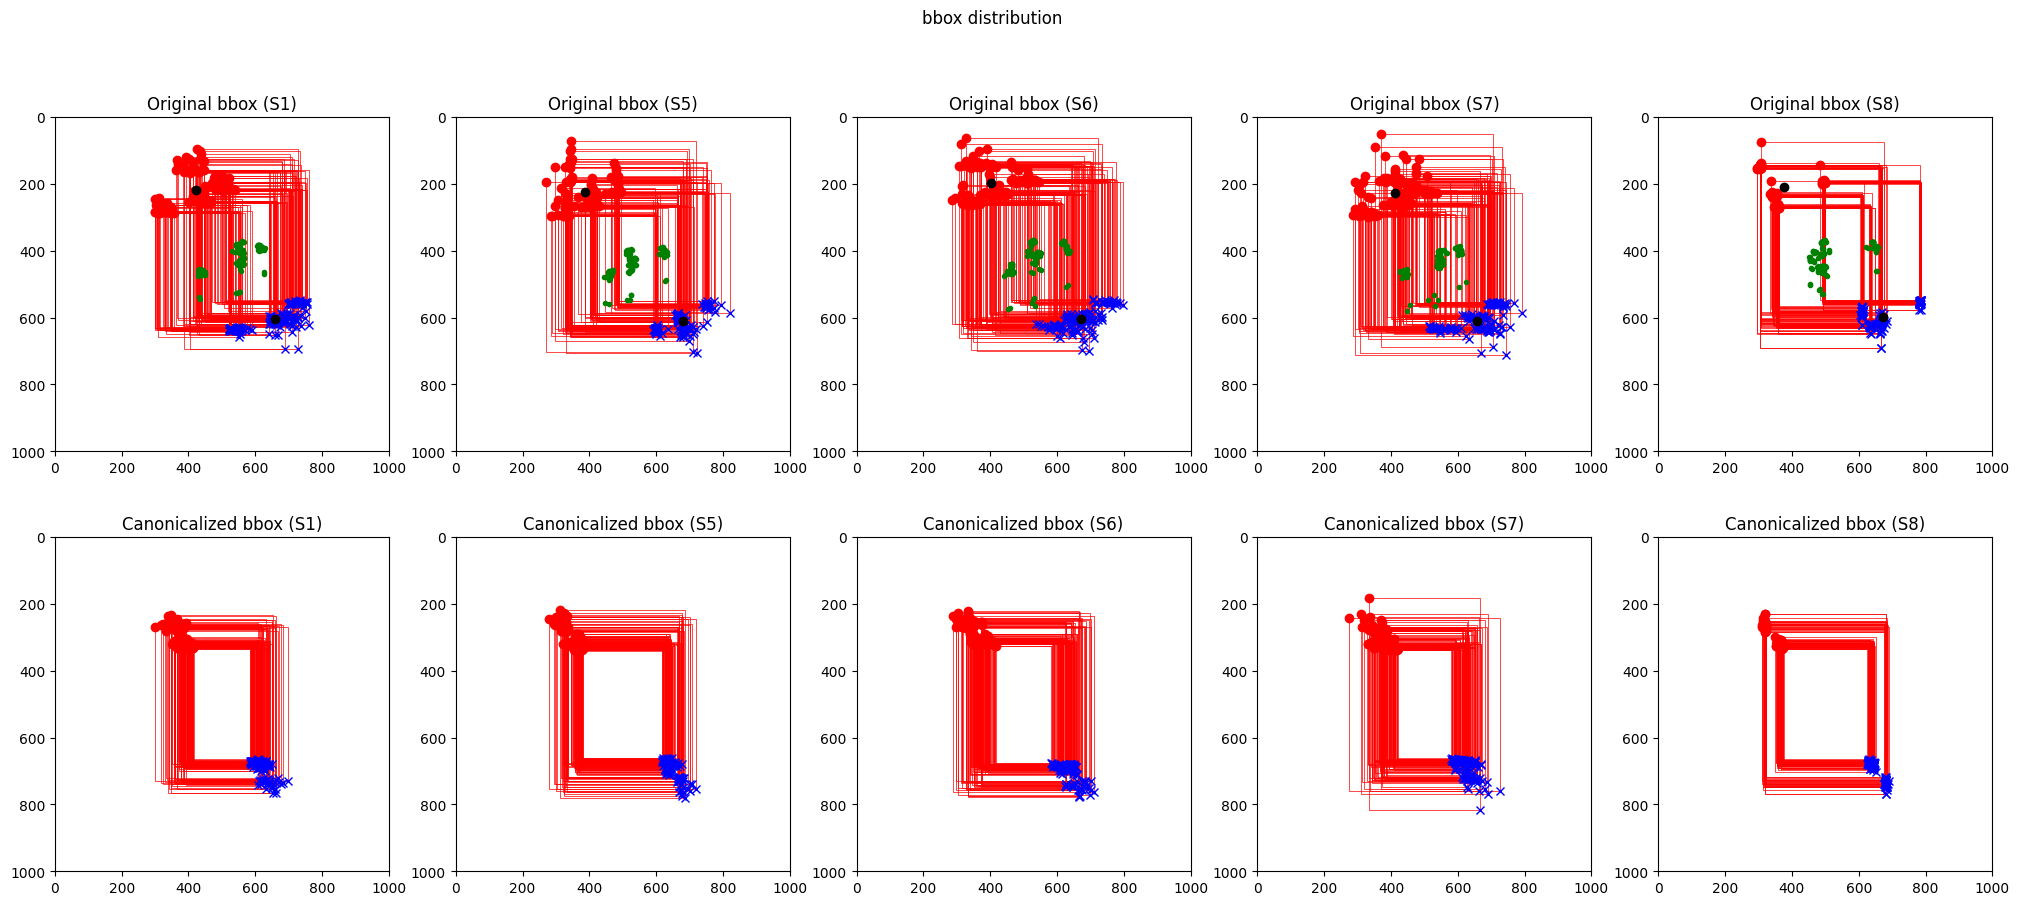

In [5]:
%matplotlib inline
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
for i, ax in enumerate(axs.ravel()):
    ax.set_xlim(0, 1000)
    ax.set_ylim(1000, 0)
    ax.set_aspect('equal')
    if i == 0 or i == 5: subject = 'S1'
    elif i == 1 or i == 6: subject = 'S5'
    elif i == 2 or i == 7: subject = 'S6'
    elif i == 3 or i == 8: subject = 'S7'
    elif i == 4 or i == 9: subject = 'S8'
    if i > 4: canonical = True
    else: canonical = False
    
    max_left_list = data_dict[subject]['max_left_list']
    max_right_list = data_dict[subject]['max_right_list']
    max_top_list = data_dict[subject]['max_top_list']
    max_bottom_list = data_dict[subject]['max_bottom_list']
    mean_center_list = data_dict[subject]['mean_center_list']
    if not canonical:
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        ax.plot(max_left_list.mean(), max_top_list.mean(), 'ko', label='mean of max left_top of bbox')
        ax.plot(max_right_list.mean(), max_bottom_list.mean(), 'ko', label='mean of max right_bottom of bbox')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_title(f'Original bbox ({subject})')
    else:
        ax.set_title(f'Canonicalized bbox ({subject})')
        for i in range(len(max_left_list)):
            center_x = (max_left_list[i] + max_right_list[i])/2
            center_y = (max_top_list[i] + max_bottom_list[i])/2
            max_left_canonical = max_left_list[i]-center_x+500
            max_right_canonical = max_right_list[i]-center_x+500
            max_top_canonical = max_top_list[i]-center_y+500
            max_bottom_canonical = max_bottom_list[i]-center_y+500
            ax.plot(max_left_canonical, max_top_canonical, 'ro')
            ax.plot(max_right_canonical, max_bottom_canonical, 'bx')
            draw_bbox(ax, [max_left_canonical, max_top_canonical, max_right_canonical, max_bottom_canonical], color="red", linewidth=0.5)

plt.suptitle(f'bbox distribution')
plt.show()
    

### Generate different bbox distribution

In [209]:
cam_param[camera_id]

{'proj': array([[-1.25180105e+03,  3.45455720e+01, -7.50844361e+01,
          2.57746738e+03],
        [-1.44574466e+02, -2.46388580e+02, -1.22160400e+03,
          3.46740749e+03],
        [-4.22285571e-01, -8.85601786e-01, -1.93350390e-01,
          5.51874048e+00]]),
 'ext': {'R': [[-0.9042074184788829,
    0.42657831374650107,
    0.020973473936051274],
   [0.06390493744399675, 0.18368565260974637, -0.9809055713959477],
   [-0.4222855708380685, -0.8856017859436166, -0.1933503902128034]],
  't': [[-219.3059666108619], [544.4787497640639], [5518.740477016156]]},
 'int': {'calibration_matrix': [[1145.04940458804, 0.0, 512.541504956548],
   [0.0, 1143.78109572365, 515.4514869776],
   [0.0, 0.0, 1.0]],
  'distortion': [-0.207098910824901,
   0.247775183068982,
   -0.00142447157470321,
   -0.000975698859470499,
   -0.00307515035078854]},
 'id': '54138969',
 'W': 1000,
 'H': 1002,
 'C': array([[2.09739151],
        [4.88094466],
        [1.60573247]])}

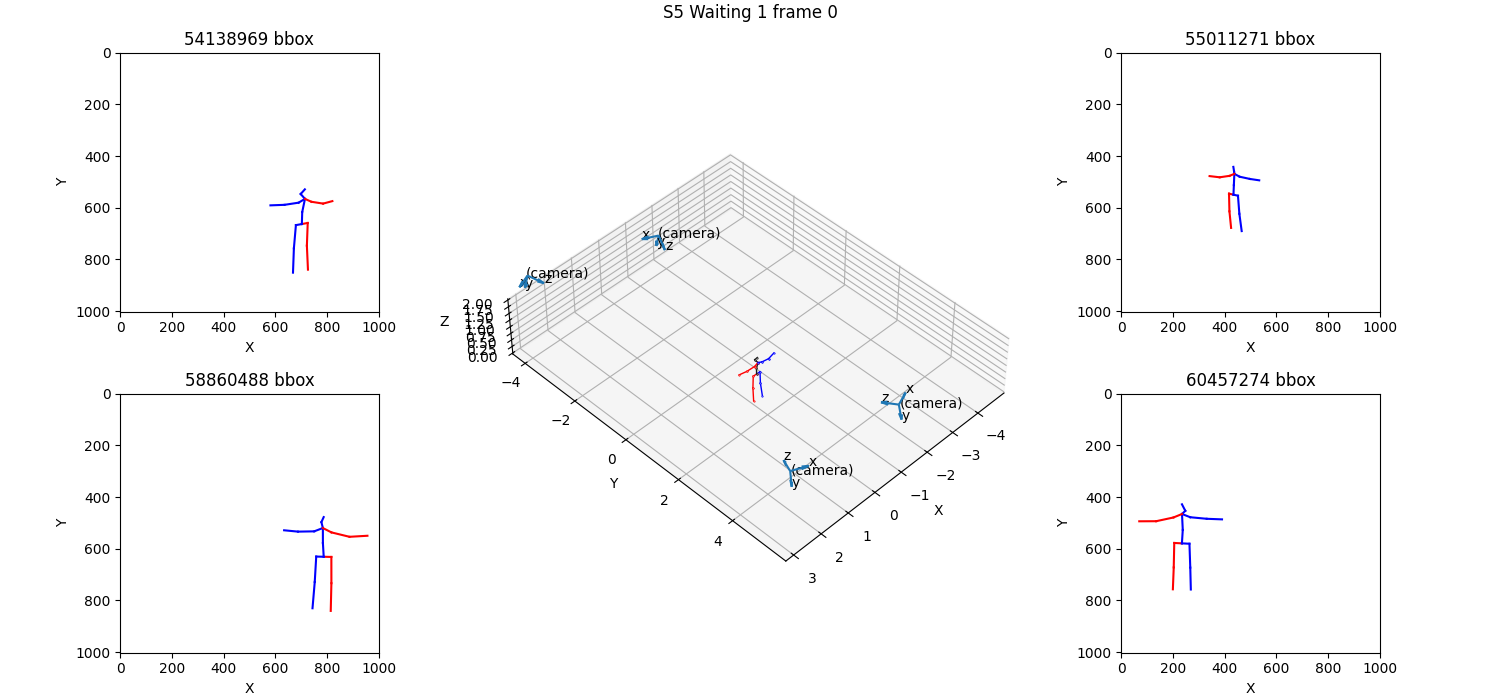

In [6]:
subject = 'S5'
action = 'Waiting 1'
camera_id = '54138969'

pose3d_list = h36m_3d_world[subject][action]['positions']
cam_info = h36m_3d_world[subject][action]['cameras']
cam_param = get_cam_param(cam_info, subject, h36m_cam_param)

trans = np.zeros(3) + np.array([-1, -0.0, -1.0])
# rand_trans = np.random.uniform(-1, 1)
# trans[:2] += rand_trans
rot = np.eye(3) # Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()

frame_num = 0
world_3d = np.array(pose3d_list[frame_num])
modified = world_3d.copy()
modified += trans
world_3d = modified

camera_list = []
img_2d_list = []
bbox_list = []
cam_id_list = []
for camera_id in cam_param.keys():
    calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
    R = np.array(cam_param[camera_id]['ext']['R'])
    t = np.array(cam_param[camera_id]['ext']['t'])/1000
    H = cam_param[camera_id]['H']
    W = cam_param[camera_id]['W']
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 

    # virtual camera 
    C = - R.T @ t
    cam_origin = C

    forward = [1, 0, 0]
    left = [0, -1, 0]
    up = np.cross(forward, left)
    cam_default_R = np.array([left, up, forward]) # default camera orientation

    camera = Camera(origin=cam_origin, 
                    calib_mat=calibration_matrix, 
                    cam_default_R=R, 
                    IMAGE_HEIGHT=H, 
                    IMAGE_WIDTH=W,
                    cam_name='test')
    camera_list.append(camera)

    # world to camera
    pos = copy.deepcopy(world_3d)
    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
    cam_3d_hat = get_rootrel_pose(cam_3d)

    # camera to image
    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
    img_2d_list.append(img_2d)
    bbox = get_bbox_from_pose2d(img_2d)
    bbox_list.append(bbox)
    cam_id_list.append(camera_id)

%matplotlib widget
fig = plt.figure(2, figsize=(15, 7), layout="constrained")
fig.clear()
axd = fig.subplot_mosaic(
    """
    BAC
    DAE
    """,
    per_subplot_kw={('A'): {'projection': '3d'}}
)
axA = axes_3d(ax=axd['A'], xlim=(-4+world_3d[0,0], 4+world_3d[0,0]), ylim=(-5+world_3d[0,1], 5+world_3d[0,1]), zlim=(0, 2), view=(45, 45))
axB = axes_2d(ax=axd['B'], W=W, H=H)
axC = axes_2d(ax=axd['C'], W=W, H=H)
axD = axes_2d(ax=axd['D'], W=W, H=H)
axE = axes_2d(ax=axd['E'], W=W, H=H)
draw_3d_pose(axA, world_3d)
plt.sca(axA)
for camera in camera_list:
    camera.cam_frame.draw3d(show_name=True)
for i, ax in enumerate([axB, axC, axD, axE]):
    draw_2d_pose(ax, img_2d_list[i])
    #draw_bbox(ax, bbox)
    ax.set_title(f'{cam_id_list[i]} bbox')
plt.suptitle(f'{subject} {action} frame {frame_num}')
plt.show()

In [234]:
camera_list[0].cam_name

'test'

S1


100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


S5


100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


S6


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


S7


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


S8


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


S9


100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


S11


100%|██████████| 29/29 [00:15<00:00,  1.91it/s]


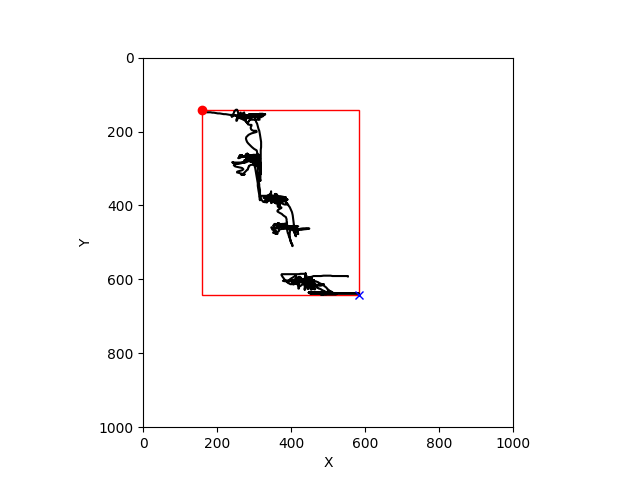

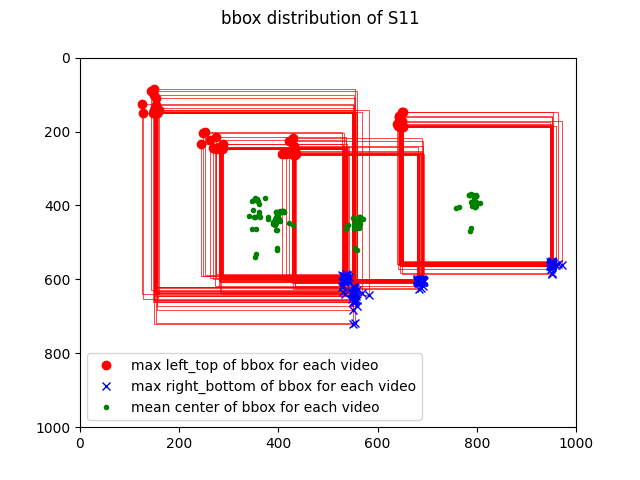

In [9]:
# subject = 'S5'
# action = 'Waiting 1'
# camera_id = '54138969'
dict_save_path = '/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/bbox_info_trans-0.5,0,-0.5.pkl'
if os.path.exists(dict_save_path):
    data_dict = readpkl(dict_save_path)
else:
    data_dict = {}
    for subject in h36m_3d_world.keys():
        data_dict[subject] = {}
        print(subject)
        save_video = False
        save_fig = True
        fig = plt.figure(0)
        fig.clear()
        #ax = axes_3d(fig, loc=121)
        ax2 = axes_2d(fig, loc=111, W=1000, H=1000)

        max_left_list = []
        max_right_list = []
        max_top_list = []
        max_bottom_list = []
        mean_center_list = []
        for action in tqdm(h36m_3d_world[subject].keys()):
            data_dict[subject][action] = {}
            pose3d_list = h36m_3d_world[subject][action]['positions']
            cam_info = h36m_3d_world[subject][action]['cameras']
            cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
            for camera_id in cam_param.keys():
                data_dict[subject][action][camera_id] = {}
                #print(subject, action, camera_id)
                calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
                R = cam_param[camera_id]['ext']['R']
                t = np.array(cam_param[camera_id]['ext']['t'])/1000
                camera_param = {
                    'intrinsic': calibration_matrix,
                    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
                }
                fx = camera_param['intrinsic'][0, 0]  
                fy = camera_param['intrinsic'][1, 1]  
                cx = camera_param['intrinsic'][0, 2]  
                cy = camera_param['intrinsic'][1, 2] 

                #frame_num = 0
                top_left_list = []
                bottom_right_list = []
                center_list = []
                if save_video:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    video_path = os.path.join(save_folder, f'check_bbox_{subject}_{action}_{camera_id}.mp4')
                    if os.path.exists(video_path): continue
                    videowriter = imageio.get_writer(video_path, fps=30)
                for frame_num in range(0, len(pose3d_list)):
                    world_3d = np.array(pose3d_list[frame_num])
                    trans = np.zeros(3) + np.array([-0.5, -0.0, -0.5])
                    rot = np.eye(3) # Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
                    modified = world_3d.copy()
                    if trans is not None:
                        modified -= np.array([modified[0][0], modified[0][1], 0])
                        modified += np.array([trans[0], trans[1], 0])
                        #modified += trans
                    if rot is not None:
                        modified = rotate_torso_by_R(modified, rot)
                    world_3d = modified

                    # world to camera
                    pos = copy.deepcopy(world_3d)
                    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
                    cam_3d_hat = get_rootrel_pose(cam_3d)

                    # camera to image
                    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                    bbox = get_bbox_from_pose2d(img_2d)

                    #clear_axes(ax2)
                    #draw_3d_pose(ax, world_3d)
                    #draw_2d_pose(ax2, img_2d)
                    #draw_bbox(ax2, bbox)
                    top_left_list.append(bbox[:2])
                    bottom_right_list.append(bbox[2:])
                    center_list.append((np.array(bbox[:2]) + np.array(bbox[2:]))/2)
                    # ax2.plot(bbox[0], bbox[1], 'kx')
                    # ax2.plot(bbox[2], bbox[3], 'kx')
                    # ax2.plot((bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2, 'kx')
                    if save_video:
                        canvas = FigureCanvas(fig)
                        canvas.draw()
                        image_from_plot = np.array(canvas.renderer._renderer)
                        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                        videowriter.append_data(image_from_plot)

                clear_axes(ax2)
                top_left_list = np.array(top_left_list)
                bottom_right_list = np.array(bottom_right_list)
                center_list = np.array(center_list)
                draw_trajectory(ax2, top_left_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, bottom_right_list, -1, recent=0, dim='2d')
                draw_trajectory(ax2, center_list, -1, recent=0, dim='2d')

                max_left = np.min(top_left_list[:, 0])
                max_top = np.min(top_left_list[:, 1])
                max_right = np.max(bottom_right_list[:, 0])
                max_bottom = np.max(bottom_right_list[:, 1])
                max_left_list.append(max_left)
                max_right_list.append(max_right)
                max_top_list.append(max_top)
                max_bottom_list.append(max_bottom)
                mean_center_list.append(np.mean(center_list, axis=0))
                ax2.plot(max_left, max_top, 'ro')
                ax2.plot(max_right, max_bottom, 'bx')
                draw_bbox(ax2, [max_left, max_top, max_right, max_bottom])

                data_dict[subject][action][camera_id]['top_left_list'] = top_left_list
                data_dict[subject][action][camera_id]['bottom_right_list'] = bottom_right_list
                data_dict[subject][action][camera_id]['center_list'] = center_list
                data_dict[subject][action][camera_id]['max_bbox'] = np.array([max_left, max_top, max_right, max_bottom]) # x1, y1, x2, y2
                

                if save_video:
                    canvas = FigureCanvas(fig)
                    canvas.draw()
                    image_from_plot = np.array(canvas.renderer._renderer)
                    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
                    videowriter.append_data(image_from_plot)
                    videowriter.close()
                #else:
                #    plt.show()
                if save_fig:
                    save_folder = f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}'
                    if not os.path.exists(save_folder): os.makedirs(save_folder)
                    fig_path = os.path.join(save_folder, f'check_bbox_area_{subject}_{action}_{camera_id}.png')
                    if os.path.exists(fig_path): continue
                    fig.savefig(fig_path)

                #break
            #break
        max_left_list = np.array(max_left_list)
        max_right_list = np.array(max_right_list)
        max_top_list = np.array(max_top_list)
        max_bottom_list = np.array(max_bottom_list)
        mean_center_list = np.array(mean_center_list)
        data_dict[subject]['max_left_list'] = max_left_list
        data_dict[subject]['max_right_list'] = max_right_list
        data_dict[subject]['max_top_list'] = max_top_list
        data_dict[subject]['max_bottom_list'] = max_bottom_list
        data_dict[subject]['mean_center_list'] = mean_center_list

        fig = plt.figure(1)
        fig.clear()
        ax = fig.add_subplot(111)
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_xlim(0, 1000)
        ax.set_ylim(1000, 0)
        ax.legend()
        plt.suptitle(f'bbox distribution of {subject}')
        plt.savefig(f'/home/hrai/codes/MotionBERT/input_videos/H36M_from_generation/{subject}/bbox_distribution.png')

    savepkl(data_dict, dict_save_path)

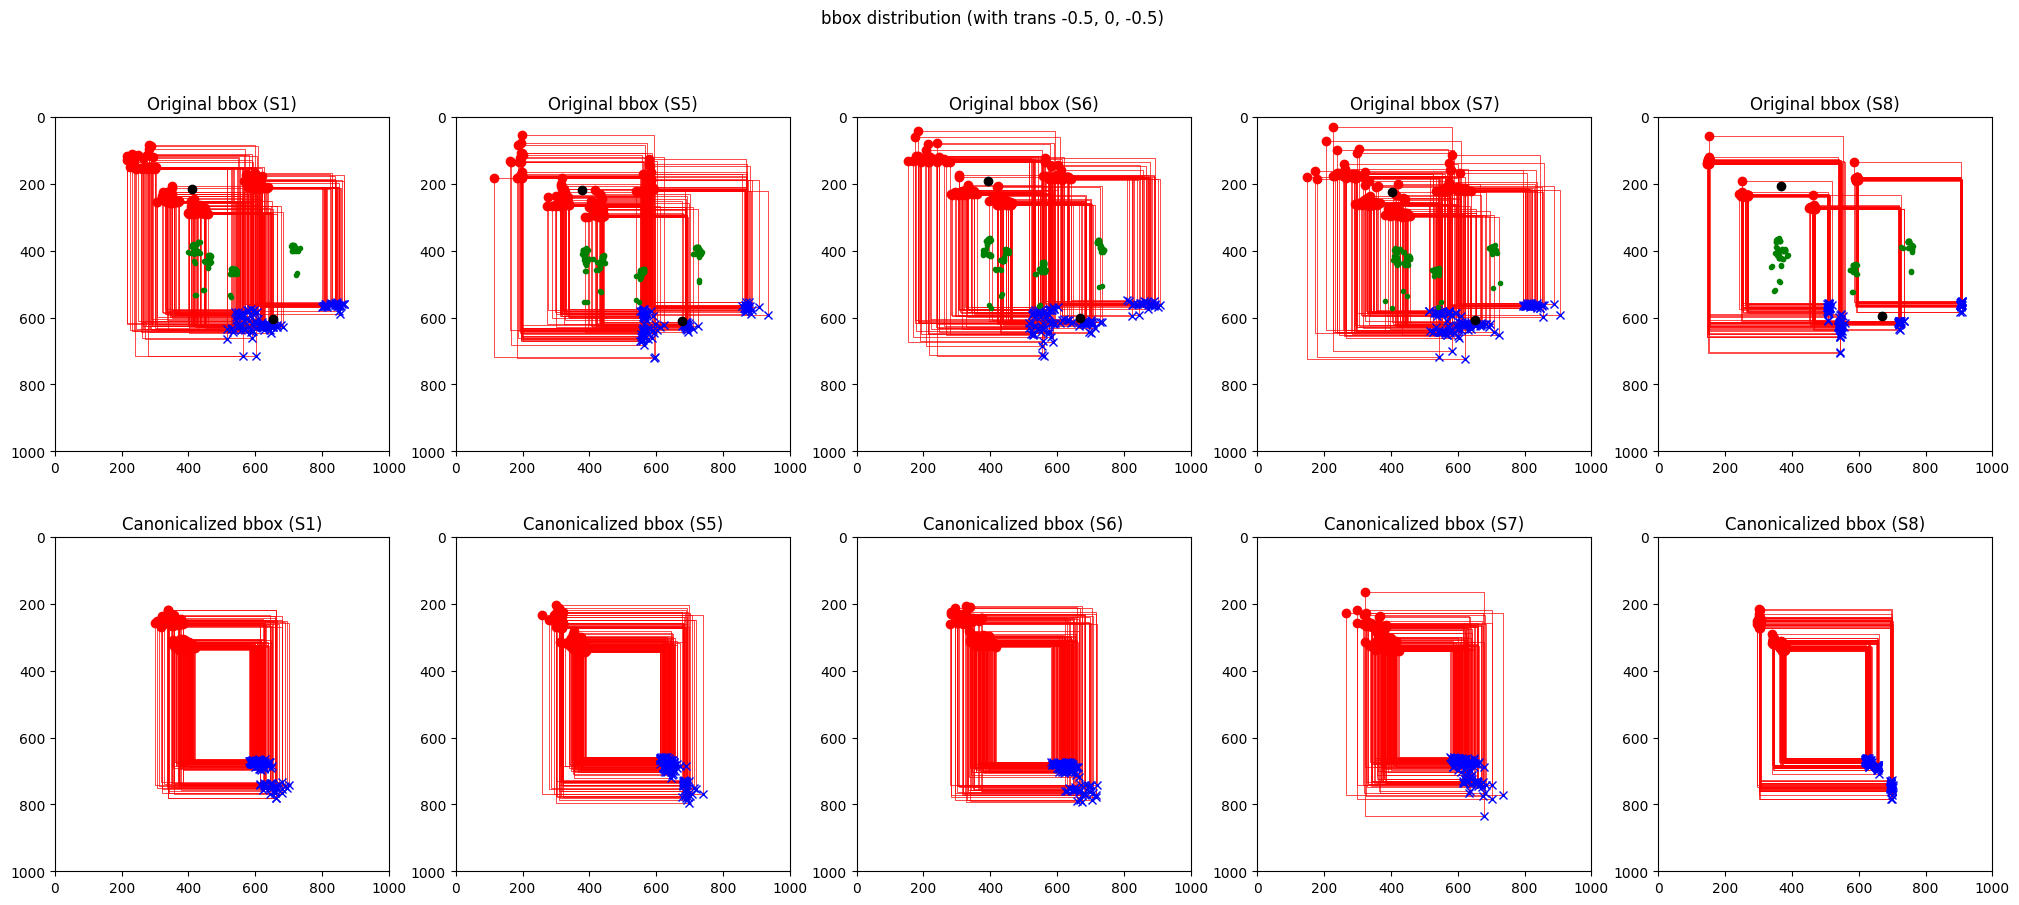

In [11]:
%matplotlib inline
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
for i, ax in enumerate(axs.ravel()):
    ax.set_xlim(0, 1000)
    ax.set_ylim(1000, 0)
    ax.set_aspect('equal')
    if i == 0 or i == 5: subject = 'S1'
    elif i == 1 or i == 6: subject = 'S5'
    elif i == 2 or i == 7: subject = 'S6'
    elif i == 3 or i == 8: subject = 'S7'
    elif i == 4 or i == 9: subject = 'S8'
    if i > 4: canonical = True
    else: canonical = False
    
    max_left_list = data_dict[subject]['max_left_list']
    max_right_list = data_dict[subject]['max_right_list']
    max_top_list = data_dict[subject]['max_top_list']
    max_bottom_list = data_dict[subject]['max_bottom_list']
    mean_center_list = data_dict[subject]['mean_center_list']
    if not canonical:
        ax.plot(max_left_list, max_top_list, 'ro', label='max left_top of bbox for each video')
        ax.plot(max_right_list, max_bottom_list, 'bx', label='max right_bottom of bbox for each video')
        ax.plot(mean_center_list[:, 0], mean_center_list[:, 1], 'g.', label='mean center of bbox for each video')
        ax.plot(max_left_list.mean(), max_top_list.mean(), 'ko', label='mean of max left_top of bbox')
        ax.plot(max_right_list.mean(), max_bottom_list.mean(), 'ko', label='mean of max right_bottom of bbox')
        for i in range(len(max_left_list)):
            draw_bbox(ax, [max_left_list[i], max_top_list[i], max_right_list[i], max_bottom_list[i]], color="red", linewidth=0.5)
        ax.set_title(f'Original bbox ({subject})')
    else:
        ax.set_title(f'Canonicalized bbox ({subject})')
        for i in range(len(max_left_list)):
            center_x = (max_left_list[i] + max_right_list[i])/2
            center_y = (max_top_list[i] + max_bottom_list[i])/2
            max_left_canonical = max_left_list[i]-center_x+500
            max_right_canonical = max_right_list[i]-center_x+500
            max_top_canonical = max_top_list[i]-center_y+500
            max_bottom_canonical = max_bottom_list[i]-center_y+500
            ax.plot(max_left_canonical, max_top_canonical, 'ro')
            ax.plot(max_right_canonical, max_bottom_canonical, 'bx')
            draw_bbox(ax, [max_left_canonical, max_top_canonical, max_right_canonical, max_bottom_canonical], color="red", linewidth=0.5)

plt.suptitle(f'bbox distribution (with trans -0.5, 0, -0.5)')
plt.show()
    

### Generate pkl

In [12]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_test_trans-0.5,0,-0.5_pkl'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [16]:
pass_subject = ['S5']
pass_action = ['Waiting 1']
pass_camera_id = ['54138969']
for subject in ['S5', 'S6', 'S7', 'S8']:
    #if subject not in pass_subject: continue
    action_list = h36m_3d_world[subject].keys()
    for action in action_list:
        #if action not in pass_action: continue
        pose3d_list_h36m = h36m_3d_world[subject][action]['positions']
        cam_info = h36m_3d_world[subject][action]['cameras']
        cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
        for camera_id in cam_param.keys():
            #if camera_id not in pass_camera_id: continue
            print(subject, action, camera_id)
            #print(cam_param[cam_id])
            calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
            R = cam_param[camera_id]['ext']['R']
            t = np.array(cam_param[camera_id]['ext']['t'])/1000
            camera_param = {
                'intrinsic': calibration_matrix,
                'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
            }
            #print(camera_param)
            available_frames = list(range(len(pose3d_list_h36m)))
            generate_kookmin_pkl_for_each_video(pose3d_list=pose3d_list_h36m.copy(), 
                                                available_frames=available_frames.copy(), 
                                                subject=subject, 
                                                camera_id=camera_id, 
                                                action=action, 
                                                phase='', 
                                                camera_param=camera_param.copy(), 
                                                save_folder=save_folder, 
                                                trans=np.array([-0.5, 0, -0.5]), 
                                                rot=None, 
                                                centered_root=False, # True: root joint을 (0, 0, 0)으로 이동, False: 원래 위치
                                                overwrite=False)


S5 Waiting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_test_trans-0.5,0,-0.5_pkl/S5_54138969_Waiting 1.pkl exists
S5 Waiting 1 55011271


  0%|          | 0/4517 [00:00<?, ?it/s]

100%|██████████| 4517/4517 [01:13<00:00, 61.56it/s]


S5 Waiting 1 58860488


100%|██████████| 4517/4517 [00:59<00:00, 76.46it/s]


S5 Waiting 1 60457274


100%|██████████| 4517/4517 [00:35<00:00, 125.85it/s]


S5 Sitting 54138969


100%|██████████| 3878/3878 [01:10<00:00, 55.11it/s]


S5 Sitting 55011271


100%|██████████| 3878/3878 [01:09<00:00, 55.84it/s]


S5 Sitting 58860488


100%|██████████| 3878/3878 [01:01<00:00, 63.36it/s]


S5 Sitting 60457274


100%|██████████| 3878/3878 [00:36<00:00, 107.02it/s]


S5 Waiting 2 54138969


100%|██████████| 4856/4856 [01:12<00:00, 67.10it/s]


S5 Waiting 2 55011271


100%|██████████| 4856/4856 [01:15<00:00, 63.90it/s]


S5 Waiting 2 58860488


100%|██████████| 4856/4856 [01:01<00:00, 78.53it/s]


S5 Waiting 2 60457274


100%|██████████| 4856/4856 [00:37<00:00, 128.57it/s]


S5 Smoking 54138969


100%|██████████| 3421/3421 [00:57<00:00, 59.99it/s]


S5 Smoking 55011271


100%|██████████| 3421/3421 [00:57<00:00, 59.21it/s]


S5 Smoking 58860488


100%|██████████| 3421/3421 [00:48<00:00, 70.40it/s]


S5 Smoking 60457274


100%|██████████| 3421/3421 [00:28<00:00, 118.59it/s]


S5 WalkTogether 1 54138969


100%|██████████| 3016/3016 [00:44<00:00, 68.14it/s]


S5 WalkTogether 1 55011271


100%|██████████| 3016/3016 [00:46<00:00, 65.48it/s]


S5 WalkTogether 1 58860488


100%|██████████| 3016/3016 [00:38<00:00, 77.92it/s]


S5 WalkTogether 1 60457274


100%|██████████| 3016/3016 [00:23<00:00, 129.05it/s]


S5 Discussion 2 54138969


100%|██████████| 6090/6090 [01:32<00:00, 65.71it/s]


S5 Discussion 2 55011271


100%|██████████| 6090/6090 [01:36<00:00, 63.27it/s]


S5 Discussion 2 58860488


100%|██████████| 6090/6090 [01:21<00:00, 74.65it/s]


S5 Discussion 2 60457274


100%|██████████| 6090/6090 [00:47<00:00, 127.90it/s]


S5 Greeting 1 54138969


100%|██████████| 1474/1474 [00:22<00:00, 64.78it/s]


S5 Greeting 1 55011271


100%|██████████| 1474/1474 [00:23<00:00, 63.43it/s]


S5 Greeting 1 58860488


100%|██████████| 1474/1474 [00:19<00:00, 77.01it/s]


S5 Greeting 1 60457274


100%|██████████| 1474/1474 [00:11<00:00, 124.75it/s]


S5 Directions 2 54138969


100%|██████████| 2067/2067 [00:28<00:00, 72.68it/s]


S5 Directions 2 55011271


100%|██████████| 2067/2067 [00:29<00:00, 69.54it/s]


S5 Directions 2 58860488


100%|██████████| 2067/2067 [00:24<00:00, 83.50it/s]


S5 Directions 2 60457274


100%|██████████| 2067/2067 [00:15<00:00, 133.15it/s]


S5 Phoning 54138969


100%|██████████| 2085/2085 [00:37<00:00, 55.00it/s]


S5 Phoning 55011271


100%|██████████| 2085/2085 [00:37<00:00, 55.33it/s]


S5 Phoning 58860488


100%|██████████| 2085/2085 [00:31<00:00, 65.27it/s]


S5 Phoning 60457274


100%|██████████| 2085/2085 [00:19<00:00, 109.35it/s]


S5 Phoning 1 54138969


100%|██████████| 3277/3277 [00:53<00:00, 61.80it/s]


S5 Phoning 1 55011271


100%|██████████| 3277/3277 [00:54<00:00, 60.61it/s]


S5 Phoning 1 58860488


100%|██████████| 3277/3277 [00:46<00:00, 70.84it/s] 


S5 Phoning 1 60457274


100%|██████████| 3277/3277 [00:27<00:00, 119.04it/s]


S5 Smoking 1 54138969


100%|██████████| 3201/3201 [00:53<00:00, 59.72it/s]


S5 Smoking 1 55011271


100%|██████████| 3201/3201 [00:53<00:00, 59.42it/s]


S5 Smoking 1 58860488


100%|██████████| 3201/3201 [00:47<00:00, 68.04it/s]


S5 Smoking 1 60457274


100%|██████████| 3201/3201 [00:27<00:00, 116.45it/s]


S5 Greeting 2 54138969


100%|██████████| 3199/3199 [00:47<00:00, 67.25it/s]


S5 Greeting 2 55011271


100%|██████████| 3199/3199 [00:48<00:00, 65.84it/s]


S5 Greeting 2 58860488


100%|██████████| 3199/3199 [00:41<00:00, 77.93it/s] 


S5 Greeting 2 60457274


100%|██████████| 3199/3199 [00:24<00:00, 129.43it/s]


S5 WalkTogether 54138969


100%|██████████| 2984/2984 [00:45<00:00, 65.48it/s]


S5 WalkTogether 55011271


100%|██████████| 2984/2984 [00:46<00:00, 64.08it/s]


S5 WalkTogether 58860488


100%|██████████| 2984/2984 [00:37<00:00, 78.74it/s]


S5 WalkTogether 60457274


100%|██████████| 2984/2984 [00:24<00:00, 124.19it/s]


S5 Sitting 1 54138969


100%|██████████| 3937/3937 [01:14<00:00, 53.16it/s]


S5 Sitting 1 55011271


100%|██████████| 3937/3937 [01:13<00:00, 53.84it/s]


S5 Sitting 1 58860488


100%|██████████| 3937/3937 [01:03<00:00, 62.18it/s]


S5 Sitting 1 60457274


100%|██████████| 3937/3937 [00:37<00:00, 103.72it/s]


S5 SittingDown 54138969


100%|██████████| 5203/5203 [01:35<00:00, 54.29it/s]


S5 SittingDown 55011271


100%|██████████| 5203/5203 [01:39<00:00, 52.53it/s]


S5 SittingDown 58860488


100%|██████████| 5203/5203 [01:25<00:00, 60.63it/s]


S5 SittingDown 60457274


100%|██████████| 5203/5203 [00:53<00:00, 97.45it/s] 


S5 SittingDown 1 54138969


100%|██████████| 3926/3926 [01:08<00:00, 57.05it/s]


S5 SittingDown 1 55011271


100%|██████████| 3926/3926 [01:11<00:00, 55.09it/s]


S5 SittingDown 1 58860488


100%|██████████| 3926/3926 [01:02<00:00, 62.40it/s]


S5 SittingDown 1 60457274


100%|██████████| 3926/3926 [00:39<00:00, 99.90it/s] 


S5 Discussion 3 54138969


100%|██████████| 5935/5935 [01:30<00:00, 65.25it/s]


S5 Discussion 3 55011271


100%|██████████| 5935/5935 [01:32<00:00, 63.90it/s]


S5 Discussion 3 58860488


100%|██████████| 5935/5935 [01:17<00:00, 76.86it/s] 


S5 Discussion 3 60457274


100%|██████████| 5935/5935 [00:46<00:00, 127.20it/s]


S5 Directions 1 54138969


100%|██████████| 4973/4973 [01:13<00:00, 67.26it/s]


S5 Directions 1 55011271


100%|██████████| 4973/4973 [01:13<00:00, 67.87it/s]


S5 Directions 1 58860488


100%|██████████| 4973/4973 [01:00<00:00, 81.96it/s]


S5 Directions 1 60457274


100%|██████████| 4973/4973 [00:36<00:00, 134.41it/s]


S5 Purchases 54138969


100%|██████████| 3124/3124 [00:45<00:00, 68.05it/s]


S5 Purchases 55011271


100%|██████████| 3124/3124 [00:46<00:00, 66.86it/s]


S5 Purchases 58860488


100%|██████████| 3124/3124 [00:41<00:00, 74.73it/s]


S5 Purchases 60457274


100%|██████████| 3124/3124 [00:24<00:00, 125.07it/s]


S5 Walking 1 54138969


100%|██████████| 3000/3000 [00:47<00:00, 62.74it/s]


S5 Walking 1 55011271


100%|██████████| 3000/3000 [00:50<00:00, 59.01it/s]


S5 Walking 1 58860488


100%|██████████| 3000/3000 [00:42<00:00, 71.18it/s]


S5 Walking 1 60457274


100%|██████████| 3000/3000 [00:25<00:00, 116.25it/s]


S5 WalkDog 1 54138969


100%|██████████| 1937/1937 [00:27<00:00, 70.09it/s]


S5 WalkDog 1 55011271


100%|██████████| 1937/1937 [00:29<00:00, 65.21it/s]


S5 WalkDog 1 58860488


100%|██████████| 1937/1937 [00:24<00:00, 79.00it/s]


S5 WalkDog 1 60457274


100%|██████████| 1937/1937 [00:15<00:00, 127.45it/s]


S5 Walking 54138969


100%|██████████| 2521/2521 [00:41<00:00, 60.95it/s]


S5 Walking 55011271


100%|██████████| 2521/2521 [00:43<00:00, 57.73it/s]


S5 Walking 58860488


100%|██████████| 2521/2521 [00:35<00:00, 71.47it/s]


S5 Walking 60457274


100%|██████████| 2521/2521 [00:21<00:00, 117.08it/s]


S5 Eating 54138969


100%|██████████| 2331/2331 [00:36<00:00, 63.43it/s]


S5 Eating 55011271


100%|██████████| 2331/2331 [00:36<00:00, 63.05it/s]


S5 Eating 58860488


100%|██████████| 2331/2331 [00:31<00:00, 73.02it/s]


S5 Eating 60457274


100%|██████████| 2331/2331 [00:18<00:00, 123.18it/s]


S5 Photo 2 54138969


100%|██████████| 2782/2782 [00:43<00:00, 64.24it/s]


S5 Photo 2 55011271


100%|██████████| 2782/2782 [00:44<00:00, 62.19it/s]


S5 Photo 2 58860488


100%|██████████| 2782/2782 [00:37<00:00, 73.50it/s] 


S5 Photo 2 60457274


100%|██████████| 2782/2782 [00:22<00:00, 124.02it/s]


S5 Posing 54138969


100%|██████████| 1885/1885 [00:27<00:00, 69.80it/s]


S5 Posing 55011271


100%|██████████| 1885/1885 [00:28<00:00, 65.93it/s]


S5 Posing 58860488


100%|██████████| 1885/1885 [00:23<00:00, 81.91it/s] 


S5 Posing 60457274


100%|██████████| 1885/1885 [00:14<00:00, 126.86it/s]


S5 Posing 1 54138969


100%|██████████| 2245/2245 [00:32<00:00, 68.73it/s]


S5 Posing 1 55011271


100%|██████████| 2245/2245 [00:32<00:00, 68.94it/s]


S5 Posing 1 58860488


100%|██████████| 2245/2245 [00:27<00:00, 80.83it/s]


S5 Posing 1 60457274


100%|██████████| 2245/2245 [00:16<00:00, 133.43it/s]


S5 WalkDog 54138969


100%|██████████| 2135/2135 [00:30<00:00, 69.47it/s]


S5 WalkDog 55011271


100%|██████████| 2135/2135 [00:32<00:00, 66.54it/s]


S5 WalkDog 58860488


100%|██████████| 2135/2135 [00:26<00:00, 80.08it/s] 


S5 WalkDog 60457274


100%|██████████| 2135/2135 [00:16<00:00, 129.10it/s]


S5 Photo 54138969


100%|██████████| 3325/3325 [00:49<00:00, 66.79it/s]


S5 Photo 55011271


100%|██████████| 3325/3325 [00:49<00:00, 67.32it/s]


S5 Photo 58860488


100%|██████████| 3325/3325 [00:41<00:00, 79.18it/s] 


S5 Photo 60457274


100%|██████████| 3325/3325 [00:25<00:00, 132.34it/s]


S5 Purchases 1 54138969


100%|██████████| 2479/2479 [00:35<00:00, 69.18it/s]


S5 Purchases 1 55011271


100%|██████████| 2479/2479 [00:35<00:00, 69.16it/s]


S5 Purchases 1 58860488


100%|██████████| 2479/2479 [00:31<00:00, 78.89it/s]


S5 Purchases 1 60457274


100%|██████████| 2479/2479 [00:18<00:00, 134.64it/s]


S5 Eating 1 54138969


100%|██████████| 3276/3276 [00:51<00:00, 63.70it/s]


S5 Eating 1 55011271


100%|██████████| 3276/3276 [00:50<00:00, 64.67it/s]


S5 Eating 1 58860488


100%|██████████| 3276/3276 [00:43<00:00, 75.44it/s]


S5 Eating 1 60457274


100%|██████████| 3276/3276 [00:27<00:00, 118.44it/s]


S6 Posing 2 54138969


100%|██████████| 1159/1159 [00:14<00:00, 77.73it/s]


S6 Posing 2 55011271


100%|██████████| 1159/1159 [00:14<00:00, 78.54it/s]


S6 Posing 2 58860488


100%|██████████| 1159/1159 [00:12<00:00, 90.47it/s] 


S6 Posing 2 60457274


100%|██████████| 1159/1159 [00:07<00:00, 149.55it/s]


S6 Photo 1 54138969


100%|██████████| 1775/1775 [00:22<00:00, 78.35it/s]


S6 Photo 1 55011271


100%|██████████| 1775/1775 [00:24<00:00, 73.87it/s]


S6 Photo 1 58860488


100%|██████████| 1775/1775 [00:20<00:00, 87.55it/s] 


S6 Photo 1 60457274


100%|██████████| 1775/1775 [00:12<00:00, 145.66it/s]


S6 Smoking 54138969


100%|██████████| 3173/3173 [00:44<00:00, 71.94it/s]


S6 Smoking 55011271


100%|██████████| 3173/3173 [00:43<00:00, 73.37it/s]


S6 Smoking 58860488


100%|██████████| 3173/3173 [00:38<00:00, 82.42it/s]


S6 Smoking 60457274


100%|██████████| 3173/3173 [00:22<00:00, 141.64it/s]


S6 Eating 2 54138969


100%|██████████| 2226/2226 [00:30<00:00, 72.19it/s]


S6 Eating 2 55011271


100%|██████████| 2226/2226 [00:31<00:00, 70.92it/s]


S6 Eating 2 58860488


100%|██████████| 2226/2226 [00:27<00:00, 81.67it/s] 


S6 Eating 2 60457274


100%|██████████| 2226/2226 [00:15<00:00, 140.95it/s]


S6 WalkTogether 1 54138969


100%|██████████| 1629/1629 [00:19<00:00, 84.42it/s] 


S6 WalkTogether 1 55011271


100%|██████████| 1629/1629 [00:20<00:00, 81.35it/s] 


S6 WalkTogether 1 58860488


100%|██████████| 1629/1629 [00:16<00:00, 97.27it/s] 


S6 WalkTogether 1 60457274


100%|██████████| 1629/1629 [00:10<00:00, 157.87it/s]


S6 Greeting 1 54138969


100%|██████████| 1980/1980 [00:22<00:00, 86.89it/s] 


S6 Greeting 1 55011271


100%|██████████| 1980/1980 [00:22<00:00, 86.83it/s] 


S6 Greeting 1 58860488


100%|██████████| 1980/1980 [00:19<00:00, 100.95it/s]


S6 Greeting 1 60457274


100%|██████████| 1980/1980 [00:11<00:00, 167.61it/s]


S6 Phoning 54138969


100%|██████████| 2086/2086 [00:29<00:00, 70.28it/s]


S6 Phoning 55011271


100%|██████████| 2086/2086 [00:29<00:00, 71.65it/s]


S6 Phoning 58860488


100%|██████████| 2086/2086 [00:25<00:00, 80.65it/s]


S6 Phoning 60457274


100%|██████████| 2086/2086 [00:15<00:00, 138.82it/s]


S6 Phoning 1 54138969


100%|██████████| 2379/2379 [00:33<00:00, 71.66it/s]


S6 Phoning 1 55011271


100%|██████████| 2379/2379 [00:33<00:00, 71.26it/s]


S6 Phoning 1 58860488


100%|██████████| 2379/2379 [00:29<00:00, 80.98it/s]


S6 Phoning 1 60457274


100%|██████████| 2379/2379 [00:17<00:00, 139.83it/s]


S6 Smoking 1 54138969


100%|██████████| 2899/2899 [00:39<00:00, 74.11it/s]


S6 Smoking 1 55011271


100%|██████████| 2899/2899 [00:38<00:00, 74.57it/s]


S6 Smoking 1 58860488


100%|██████████| 2899/2899 [00:34<00:00, 84.63it/s] 


S6 Smoking 1 60457274


100%|██████████| 2899/2899 [00:20<00:00, 142.96it/s]


S6 Discussion 1 54138969


100%|██████████| 2720/2720 [00:33<00:00, 80.41it/s]


S6 Discussion 1 55011271


100%|██████████| 2720/2720 [00:35<00:00, 77.57it/s]


S6 Discussion 1 58860488


100%|██████████| 2720/2720 [00:29<00:00, 91.27it/s] 


S6 Discussion 1 60457274


100%|██████████| 2720/2720 [00:18<00:00, 150.81it/s]


S6 WalkTogether 54138969


100%|██████████| 1590/1590 [00:19<00:00, 80.33it/s] 


S6 WalkTogether 55011271


100%|██████████| 1590/1590 [00:20<00:00, 79.27it/s]


S6 WalkTogether 58860488


100%|██████████| 1590/1590 [00:17<00:00, 92.84it/s] 


S6 WalkTogether 60457274


100%|██████████| 1590/1590 [00:10<00:00, 150.72it/s]


S6 Sitting 1 54138969


100%|██████████| 1817/1817 [00:26<00:00, 69.80it/s]


S6 Sitting 1 55011271


100%|██████████| 1817/1817 [00:25<00:00, 72.37it/s]


S6 Sitting 1 58860488


100%|██████████| 1817/1817 [00:22<00:00, 79.13it/s]


S6 Sitting 1 60457274


100%|██████████| 1817/1817 [00:13<00:00, 139.16it/s]


S6 SittingDown 54138969


100%|██████████| 1594/1594 [00:22<00:00, 70.02it/s]


S6 SittingDown 55011271


100%|██████████| 1594/1594 [00:24<00:00, 65.94it/s]


S6 SittingDown 58860488


100%|██████████| 1594/1594 [00:20<00:00, 77.50it/s]


S6 SittingDown 60457274


100%|██████████| 1594/1594 [00:13<00:00, 118.32it/s]


S6 Directions 54138969


100%|██████████| 2819/2819 [00:33<00:00, 83.69it/s]


S6 Directions 55011271


100%|██████████| 2819/2819 [00:34<00:00, 82.27it/s]


S6 Directions 58860488


100%|██████████| 2819/2819 [00:29<00:00, 96.26it/s] 


S6 Directions 60457274


100%|██████████| 2819/2819 [00:18<00:00, 153.09it/s]


S6 SittingDown 1 54138969


100%|██████████| 1873/1873 [00:27<00:00, 67.97it/s]


S6 SittingDown 1 55011271


100%|██████████| 1873/1873 [00:27<00:00, 67.54it/s] 


S6 SittingDown 1 58860488


100%|██████████| 1873/1873 [00:26<00:00, 71.92it/s] 


S6 SittingDown 1 60457274


100%|██████████| 1873/1873 [00:16<00:00, 116.22it/s]


S6 Directions 1 54138969


100%|██████████| 2843/2843 [00:32<00:00, 87.71it/s] 


S6 Directions 1 55011271


100%|██████████| 2843/2843 [00:33<00:00, 83.84it/s]


S6 Directions 1 58860488


100%|██████████| 2843/2843 [00:29<00:00, 96.69it/s] 


S6 Directions 1 60457274


100%|██████████| 2843/2843 [00:18<00:00, 157.59it/s]


S6 Purchases 54138969


100%|██████████| 1382/1382 [00:19<00:00, 72.21it/s]


S6 Purchases 55011271


100%|██████████| 1382/1382 [00:19<00:00, 70.95it/s]


S6 Purchases 58860488


100%|██████████| 1382/1382 [00:16<00:00, 84.18it/s]


S6 Purchases 60457274


100%|██████████| 1382/1382 [00:09<00:00, 144.40it/s]


S6 Walking 1 54138969


100%|██████████| 2750/2750 [00:35<00:00, 76.42it/s]


S6 Walking 1 55011271


100%|██████████| 2750/2750 [00:38<00:00, 72.23it/s]


S6 Walking 1 58860488


100%|██████████| 2750/2750 [00:32<00:00, 83.82it/s]


S6 Walking 1 60457274


100%|██████████| 2750/2750 [00:19<00:00, 143.18it/s]


S6 WalkDog 1 54138969


100%|██████████| 1996/1996 [00:26<00:00, 76.66it/s]


S6 WalkDog 1 55011271


100%|██████████| 1996/1996 [00:25<00:00, 78.73it/s]


S6 WalkDog 1 58860488


100%|██████████| 1996/1996 [00:23<00:00, 86.06it/s] 


S6 WalkDog 1 60457274


100%|██████████| 1996/1996 [00:14<00:00, 135.38it/s]


S6 Waiting 54138969


100%|██████████| 2054/2054 [00:23<00:00, 87.40it/s] 


S6 Waiting 55011271


100%|██████████| 2054/2054 [00:25<00:00, 79.65it/s]


S6 Waiting 58860488


100%|██████████| 2054/2054 [00:20<00:00, 100.99it/s]


S6 Waiting 60457274


100%|██████████| 2054/2054 [00:12<00:00, 158.26it/s]


S6 Walking 54138969


100%|██████████| 3614/3614 [00:49<00:00, 72.82it/s]


S6 Walking 55011271


100%|██████████| 3614/3614 [00:49<00:00, 72.50it/s]


S6 Walking 58860488


100%|██████████| 3614/3614 [00:42<00:00, 85.81it/s]


S6 Walking 60457274


100%|██████████| 3614/3614 [00:24<00:00, 144.83it/s]


S6 Discussion 54138969


100%|██████████| 2415/2415 [00:29<00:00, 81.82it/s]


S6 Discussion 55011271


100%|██████████| 2415/2415 [00:31<00:00, 77.49it/s]


S6 Discussion 58860488


100%|██████████| 2415/2415 [00:26<00:00, 90.49it/s] 


S6 Discussion 60457274


100%|██████████| 2415/2415 [00:16<00:00, 145.72it/s]


S6 Posing 54138969


100%|██████████| 1161/1161 [00:14<00:00, 80.59it/s]


S6 Posing 55011271


100%|██████████| 1161/1161 [00:15<00:00, 75.66it/s]


S6 Posing 58860488


100%|██████████| 1161/1161 [00:12<00:00, 90.53it/s] 


S6 Posing 60457274


100%|██████████| 1161/1161 [00:07<00:00, 147.98it/s]


S6 Greeting 54138969


100%|██████████| 1621/1621 [00:17<00:00, 90.34it/s] 


S6 Greeting 55011271


100%|██████████| 1621/1621 [00:18<00:00, 87.82it/s] 


S6 Greeting 58860488


100%|██████████| 1621/1621 [00:15<00:00, 101.78it/s]


S6 Greeting 60457274


100%|██████████| 1621/1621 [00:09<00:00, 171.40it/s]


S6 Waiting 3 54138969


100%|██████████| 2305/2305 [00:26<00:00, 88.65it/s] 


S6 Waiting 3 55011271


100%|██████████| 2305/2305 [00:27<00:00, 84.11it/s]


S6 Waiting 3 58860488


100%|██████████| 2305/2305 [00:23<00:00, 96.87it/s] 


S6 Waiting 3 60457274


100%|██████████| 2305/2305 [00:14<00:00, 154.80it/s]


S6 WalkDog 54138969


100%|██████████| 1594/1594 [00:19<00:00, 79.86it/s]


S6 WalkDog 55011271


100%|██████████| 1594/1594 [00:20<00:00, 79.39it/s]


S6 WalkDog 58860488


100%|██████████| 1594/1594 [00:17<00:00, 88.57it/s]


S6 WalkDog 60457274


100%|██████████| 1594/1594 [00:11<00:00, 142.53it/s]


S6 Photo 54138969


100%|██████████| 1672/1672 [00:20<00:00, 80.73it/s]


S6 Photo 55011271


100%|██████████| 1672/1672 [00:21<00:00, 79.34it/s]


S6 Photo 58860488


100%|██████████| 1672/1672 [00:18<00:00, 91.79it/s] 


S6 Photo 60457274


100%|██████████| 1672/1672 [00:11<00:00, 150.08it/s]


S6 Purchases 1 54138969


100%|██████████| 1332/1332 [00:17<00:00, 76.78it/s]


S6 Purchases 1 55011271


100%|██████████| 1332/1332 [00:16<00:00, 79.10it/s]


S6 Purchases 1 58860488


100%|██████████| 1332/1332 [00:14<00:00, 91.94it/s]


S6 Purchases 1 60457274


100%|██████████| 1332/1332 [00:08<00:00, 155.03it/s]


S6 Eating 1 54138969


100%|██████████| 2010/2010 [00:28<00:00, 70.76it/s]


S6 Eating 1 55011271


100%|██████████| 2010/2010 [00:28<00:00, 71.41it/s]


S6 Eating 1 58860488


100%|██████████| 2010/2010 [00:26<00:00, 76.99it/s]


S6 Eating 1 60457274


100%|██████████| 2010/2010 [00:14<00:00, 138.34it/s]


S6 Sitting 2 54138969


100%|██████████| 1998/1998 [00:28<00:00, 70.02it/s]


S6 Sitting 2 55011271


100%|██████████| 1998/1998 [00:27<00:00, 73.46it/s]


S6 Sitting 2 58860488


100%|██████████| 1998/1998 [00:26<00:00, 76.30it/s]


S6 Sitting 2 60457274


100%|██████████| 1998/1998 [00:15<00:00, 130.15it/s]


S7 Waiting 1 54138969


100%|██████████| 4201/4201 [01:02<00:00, 67.39it/s]


S7 Waiting 1 55011271


100%|██████████| 4201/4201 [01:04<00:00, 65.24it/s]


S7 Waiting 1 58860488


100%|██████████| 4201/4201 [00:56<00:00, 74.96it/s]


S7 Waiting 1 60457274


100%|██████████| 4201/4201 [00:33<00:00, 124.24it/s]


S7 Sitting 54138969


100%|██████████| 2826/2826 [00:53<00:00, 53.07it/s]


S7 Sitting 55011271


100%|██████████| 2826/2826 [00:53<00:00, 52.50it/s]


S7 Sitting 58860488


100%|██████████| 2826/2826 [00:49<00:00, 57.40it/s]


S7 Sitting 60457274


100%|██████████| 2826/2826 [00:28<00:00, 100.11it/s]


S7 Photo 1 54138969


100%|██████████| 1877/1877 [00:27<00:00, 68.34it/s]


S7 Photo 1 55011271


100%|██████████| 1877/1877 [00:27<00:00, 68.23it/s]


S7 Photo 1 58860488


100%|██████████| 1877/1877 [00:23<00:00, 79.57it/s]


S7 Photo 1 60457274


100%|██████████| 1877/1877 [00:14<00:00, 132.48it/s]


S7 Waiting 2 54138969


100%|██████████| 4332/4332 [01:03<00:00, 68.19it/s]


S7 Waiting 2 55011271


100%|██████████| 4332/4332 [01:07<00:00, 64.08it/s]


S7 Waiting 2 58860488


100%|██████████| 4332/4332 [00:58<00:00, 73.82it/s]


S7 Waiting 2 60457274


100%|██████████| 4332/4332 [00:34<00:00, 125.56it/s]


S7 Smoking 54138969


100%|██████████| 4870/4870 [01:24<00:00, 57.51it/s]


S7 Smoking 55011271


100%|██████████| 4870/4870 [01:23<00:00, 58.10it/s]


S7 Smoking 58860488


100%|██████████| 4870/4870 [01:15<00:00, 64.64it/s]


S7 Smoking 60457274


100%|██████████| 4870/4870 [00:44<00:00, 110.61it/s]


S7 WalkTogether 1 54138969


100%|██████████| 2379/2379 [00:33<00:00, 70.72it/s]


S7 WalkTogether 1 55011271


100%|██████████| 2379/2379 [00:36<00:00, 65.79it/s]


S7 WalkTogether 1 58860488


100%|██████████| 2379/2379 [00:30<00:00, 77.28it/s]


S7 WalkTogether 1 60457274


100%|██████████| 2379/2379 [00:18<00:00, 127.26it/s]


S7 Greeting 1 54138969


100%|██████████| 2215/2215 [00:31<00:00, 70.42it/s]


S7 Greeting 1 55011271


100%|██████████| 2215/2215 [00:30<00:00, 73.06it/s]


S7 Greeting 1 58860488


100%|██████████| 2215/2215 [00:29<00:00, 75.72it/s]


S7 Greeting 1 60457274


100%|██████████| 2215/2215 [00:16<00:00, 136.16it/s]


S7 Phoning 2 54138969


100%|██████████| 4354/4354 [01:12<00:00, 59.87it/s]


S7 Phoning 2 55011271


100%|██████████| 4354/4354 [01:11<00:00, 60.64it/s]


S7 Phoning 2 58860488


100%|██████████| 4354/4354 [01:05<00:00, 66.31it/s]


S7 Phoning 2 60457274


100%|██████████| 4354/4354 [00:36<00:00, 118.06it/s]


S7 Phoning 54138969


100%|██████████| 3586/3586 [01:01<00:00, 58.78it/s]


S7 Phoning 55011271


100%|██████████| 3586/3586 [01:01<00:00, 58.02it/s]


S7 Phoning 58860488


100%|██████████| 3586/3586 [00:56<00:00, 63.07it/s]


S7 Phoning 60457274


100%|██████████| 3586/3586 [00:32<00:00, 111.62it/s]


S7 Smoking 1 54138969


100%|██████████| 4395/4395 [01:13<00:00, 59.99it/s]


S7 Smoking 1 55011271


100%|██████████| 4395/4395 [01:13<00:00, 59.59it/s]


S7 Smoking 1 58860488


100%|██████████| 4395/4395 [01:06<00:00, 65.85it/s]


S7 Smoking 1 60457274


100%|██████████| 4395/4395 [00:39<00:00, 110.52it/s]


S7 Discussion 1 54138969


100%|██████████| 5415/5415 [01:16<00:00, 70.39it/s] 


S7 Discussion 1 55011271


100%|██████████| 5415/5415 [01:17<00:00, 69.49it/s] 


S7 Discussion 1 58860488


100%|██████████| 5415/5415 [01:07<00:00, 80.41it/s] 


S7 Discussion 1 60457274


100%|██████████| 5415/5415 [00:40<00:00, 133.07it/s]


S7 WalkTogether 54138969


100%|██████████| 2871/2871 [00:41<00:00, 69.09it/s]


S7 WalkTogether 55011271


100%|██████████| 2871/2871 [00:44<00:00, 64.59it/s]


S7 WalkTogether 58860488


100%|██████████| 2871/2871 [00:37<00:00, 77.01it/s]


S7 WalkTogether 60457274


100%|██████████| 2871/2871 [00:22<00:00, 128.92it/s]


S7 Sitting 1 54138969


100%|██████████| 4533/4533 [01:20<00:00, 56.09it/s]


S7 Sitting 1 55011271


100%|██████████| 4533/4533 [01:21<00:00, 55.38it/s]


S7 Sitting 1 58860488


100%|██████████| 4533/4533 [01:12<00:00, 62.29it/s] 


S7 Sitting 1 60457274


100%|██████████| 4533/4533 [00:43<00:00, 105.28it/s]


S7 Walking 2 54138969


100%|██████████| 3623/3623 [00:54<00:00, 66.65it/s]


S7 Walking 2 55011271


100%|██████████| 3623/3623 [00:56<00:00, 63.79it/s]


S7 Walking 2 58860488


100%|██████████| 3623/3623 [00:51<00:00, 70.81it/s]


S7 Walking 2 60457274


100%|██████████| 3623/3623 [00:29<00:00, 122.57it/s]


S7 SittingDown 54138969


100%|██████████| 4549/4549 [01:17<00:00, 58.55it/s]


S7 SittingDown 55011271


100%|██████████| 4549/4549 [01:20<00:00, 56.86it/s]


S7 SittingDown 58860488


100%|██████████| 4549/4549 [01:11<00:00, 64.01it/s]


S7 SittingDown 60457274


100%|██████████| 4549/4549 [00:44<00:00, 103.13it/s]


S7 Directions 54138969


100%|██████████| 2949/2949 [00:41<00:00, 71.48it/s]


S7 Directions 55011271


100%|██████████| 2949/2949 [00:40<00:00, 72.37it/s]


S7 Directions 58860488


100%|██████████| 2949/2949 [00:36<00:00, 80.41it/s]


S7 Directions 60457274


100%|██████████| 2949/2949 [00:22<00:00, 133.77it/s]


S7 SittingDown 1 54138969


100%|██████████| 6343/6343 [01:54<00:00, 55.40it/s]


S7 SittingDown 1 55011271


100%|██████████| 6343/6343 [01:55<00:00, 54.71it/s]


S7 SittingDown 1 58860488


100%|██████████| 6343/6343 [01:40<00:00, 63.09it/s] 


S7 SittingDown 1 60457274


100%|██████████| 6343/6343 [01:03<00:00, 99.19it/s] 


S7 Directions 1 54138969


100%|██████████| 2549/2549 [00:36<00:00, 69.70it/s]


S7 Directions 1 55011271


100%|██████████| 2549/2549 [00:37<00:00, 67.55it/s]


S7 Directions 1 58860488


100%|██████████| 2549/2549 [00:33<00:00, 77.01it/s]


S7 Directions 1 60457274


100%|██████████| 2549/2549 [00:18<00:00, 136.73it/s]


S7 Purchases 54138969


100%|██████████| 1527/1527 [00:23<00:00, 64.18it/s]


S7 Purchases 55011271


100%|██████████| 1527/1527 [00:23<00:00, 66.21it/s]


S7 Purchases 58860488


100%|██████████| 1527/1527 [00:21<00:00, 71.58it/s]


S7 Purchases 60457274


100%|██████████| 1527/1527 [00:12<00:00, 122.65it/s]


S7 Walking 1 54138969


100%|██████████| 3636/3636 [00:57<00:00, 63.48it/s]


S7 Walking 1 55011271


100%|██████████| 3636/3636 [00:56<00:00, 64.19it/s]


S7 Walking 1 58860488


100%|██████████| 3636/3636 [00:49<00:00, 74.14it/s]


S7 Walking 1 60457274


100%|██████████| 3636/3636 [00:30<00:00, 120.95it/s]


S7 WalkDog 1 54138969


100%|██████████| 2641/2641 [00:41<00:00, 64.08it/s]


S7 WalkDog 1 55011271


100%|██████████| 2641/2641 [00:40<00:00, 65.34it/s]


S7 WalkDog 1 58860488


100%|██████████| 2641/2641 [00:37<00:00, 70.47it/s]


S7 WalkDog 1 60457274


100%|██████████| 2641/2641 [00:21<00:00, 122.11it/s]


S7 Discussion 54138969


100%|██████████| 5470/5470 [01:19<00:00, 68.77it/s]


S7 Discussion 55011271


100%|██████████| 5470/5470 [01:21<00:00, 67.11it/s]


S7 Discussion 58860488


100%|██████████| 5470/5470 [01:09<00:00, 78.82it/s]


S7 Discussion 60457274


100%|██████████| 5470/5470 [00:42<00:00, 128.51it/s]


S7 Eating 54138969


100%|██████████| 3171/3171 [00:51<00:00, 61.96it/s]


S7 Eating 55011271


100%|██████████| 3171/3171 [00:49<00:00, 63.48it/s]


S7 Eating 58860488


100%|██████████| 3171/3171 [00:47<00:00, 67.11it/s]


S7 Eating 60457274


100%|██████████| 3171/3171 [00:26<00:00, 121.26it/s]


S7 Posing 54138969


100%|██████████| 2920/2920 [00:42<00:00, 68.46it/s]


S7 Posing 55011271


100%|██████████| 2920/2920 [00:43<00:00, 67.12it/s]


S7 Posing 58860488


100%|██████████| 2920/2920 [00:36<00:00, 79.39it/s]


S7 Posing 60457274


100%|██████████| 2920/2920 [00:23<00:00, 126.54it/s]


S7 Greeting 54138969


100%|██████████| 2161/2161 [00:31<00:00, 69.49it/s]


S7 Greeting 55011271


100%|██████████| 2161/2161 [00:29<00:00, 72.12it/s]


S7 Greeting 58860488


100%|██████████| 2161/2161 [00:27<00:00, 79.25it/s] 


S7 Greeting 60457274


100%|██████████| 2161/2161 [00:15<00:00, 135.47it/s]


S7 Posing 1 54138969


100%|██████████| 2341/2341 [00:33<00:00, 70.26it/s]


S7 Posing 1 55011271


100%|██████████| 2341/2341 [00:33<00:00, 70.71it/s]


S7 Posing 1 58860488


100%|██████████| 2341/2341 [00:28<00:00, 82.65it/s] 


S7 Posing 1 60457274


100%|██████████| 2341/2341 [00:17<00:00, 137.26it/s]


S7 WalkDog 54138969


100%|██████████| 2732/2732 [00:42<00:00, 64.43it/s]


S7 WalkDog 55011271


100%|██████████| 2732/2732 [00:42<00:00, 64.52it/s]


S7 WalkDog 58860488


100%|██████████| 2732/2732 [00:37<00:00, 72.80it/s]


S7 WalkDog 60457274


100%|██████████| 2732/2732 [00:22<00:00, 122.38it/s]


S7 Photo 54138969


100%|██████████| 2155/2155 [00:31<00:00, 68.65it/s]


S7 Photo 55011271


100%|██████████| 2155/2155 [00:30<00:00, 69.64it/s]


S7 Photo 58860488


100%|██████████| 2155/2155 [00:27<00:00, 78.80it/s]


S7 Photo 60457274


100%|██████████| 2155/2155 [00:16<00:00, 128.30it/s]


S7 Purchases 1 54138969


100%|██████████| 1237/1237 [00:19<00:00, 63.37it/s]


S7 Purchases 1 55011271


100%|██████████| 1237/1237 [00:18<00:00, 65.29it/s]


S7 Purchases 1 58860488


100%|██████████| 1237/1237 [00:17<00:00, 71.25it/s]


S7 Purchases 1 60457274


100%|██████████| 1237/1237 [00:09<00:00, 125.21it/s]


S7 Eating 1 54138969


100%|██████████| 3763/3763 [01:03<00:00, 59.22it/s]


S7 Eating 1 55011271


100%|██████████| 3763/3763 [01:02<00:00, 60.61it/s]


S7 Eating 1 58860488


100%|██████████| 3763/3763 [00:54<00:00, 68.56it/s]


S7 Eating 1 60457274


100%|██████████| 3763/3763 [00:30<00:00, 121.87it/s]


S8 WalkTogether 2 54138969


100%|██████████| 2499/2499 [00:31<00:00, 78.43it/s]


S8 WalkTogether 2 55011271


100%|██████████| 2499/2499 [00:33<00:00, 75.02it/s]


S8 WalkTogether 2 58860488


100%|██████████| 2499/2499 [00:26<00:00, 95.03it/s] 


S8 WalkTogether 2 60457274


100%|██████████| 2499/2499 [00:16<00:00, 155.51it/s]


S8 Waiting 1 54138969


100%|██████████| 1612/1612 [00:20<00:00, 80.35it/s]


S8 Waiting 1 55011271


100%|██████████| 1612/1612 [00:20<00:00, 77.47it/s]


S8 Waiting 1 58860488


100%|██████████| 1612/1612 [00:16<00:00, 98.92it/s] 


S8 Waiting 1 60457274


100%|██████████| 1612/1612 [00:10<00:00, 157.96it/s]


S8 Sitting 54138969


100%|██████████| 2140/2140 [00:31<00:00, 67.84it/s]


S8 Sitting 55011271


100%|██████████| 2140/2140 [00:33<00:00, 64.68it/s]


S8 Sitting 58860488


100%|██████████| 2140/2140 [00:26<00:00, 80.94it/s] 


S8 Sitting 60457274


100%|██████████| 2140/2140 [00:16<00:00, 128.57it/s]


S8 Photo 1 54138969


100%|██████████| 1616/1616 [00:21<00:00, 76.21it/s]


S8 Photo 1 55011271


100%|██████████| 1616/1616 [00:20<00:00, 80.51it/s]


S8 Photo 1 58860488


100%|██████████| 1616/1616 [00:17<00:00, 91.24it/s] 


S8 Photo 1 60457274


100%|██████████| 1616/1616 [00:10<00:00, 160.76it/s]


S8 Smoking 54138969


100%|██████████| 3333/3333 [00:50<00:00, 66.65it/s]


S8 Smoking 55011271


100%|██████████| 3333/3333 [00:50<00:00, 65.51it/s]


S8 Smoking 58860488


100%|██████████| 3333/3333 [00:43<00:00, 77.38it/s]


S8 Smoking 60457274


100%|██████████| 3333/3333 [00:25<00:00, 132.17it/s]


S8 WalkTogether 1 54138969


100%|██████████| 2359/2359 [00:30<00:00, 77.41it/s]


S8 WalkTogether 1 55011271


100%|██████████| 2359/2359 [00:34<00:00, 68.87it/s]


S8 WalkTogether 1 58860488


100%|██████████| 2359/2359 [00:26<00:00, 89.84it/s] 


S8 WalkTogether 1 60457274


100%|██████████| 2359/2359 [00:15<00:00, 153.08it/s]


S8 Greeting 1 54138969


100%|██████████| 1598/1598 [00:18<00:00, 87.42it/s] 


S8 Greeting 1 55011271


100%|██████████| 1598/1598 [00:19<00:00, 83.72it/s]


S8 Greeting 1 58860488


100%|██████████| 1598/1598 [00:15<00:00, 101.76it/s]


S8 Greeting 1 60457274


100%|██████████| 1598/1598 [00:09<00:00, 172.74it/s]


S8 Phoning 54138969


100%|██████████| 3319/3319 [00:49<00:00, 67.38it/s]


S8 Phoning 55011271


100%|██████████| 3319/3319 [00:51<00:00, 64.52it/s]


S8 Phoning 58860488


100%|██████████| 3319/3319 [00:41<00:00, 80.29it/s]


S8 Phoning 60457274


100%|██████████| 3319/3319 [00:24<00:00, 134.10it/s]


S8 Phoning 1 54138969


100%|██████████| 2970/2970 [00:44<00:00, 67.23it/s]


S8 Phoning 1 55011271


100%|██████████| 2970/2970 [00:46<00:00, 63.69it/s]


S8 Phoning 1 58860488


100%|██████████| 2970/2970 [00:38<00:00, 77.64it/s]


S8 Phoning 1 60457274


100%|██████████| 2970/2970 [00:22<00:00, 131.93it/s]


S8 Smoking 1 54138969


100%|██████████| 2932/2932 [00:43<00:00, 67.73it/s]


S8 Smoking 1 55011271


100%|██████████| 2932/2932 [00:44<00:00, 65.41it/s]


S8 Smoking 1 58860488


100%|██████████| 2932/2932 [00:37<00:00, 77.48it/s]


S8 Smoking 1 60457274


100%|██████████| 2932/2932 [00:21<00:00, 134.12it/s]


S8 Discussion 1 54138969


100%|██████████| 1931/1931 [00:25<00:00, 75.12it/s]


S8 Discussion 1 55011271


100%|██████████| 1931/1931 [00:25<00:00, 75.03it/s]


S8 Discussion 1 58860488


100%|██████████| 1931/1931 [00:20<00:00, 92.56it/s]


S8 Discussion 1 60457274


100%|██████████| 1931/1931 [00:12<00:00, 148.80it/s]


S8 Sitting 1 54138969


100%|██████████| 2073/2073 [00:31<00:00, 65.01it/s]


S8 Sitting 1 55011271


100%|██████████| 2073/2073 [00:33<00:00, 62.01it/s]


S8 Sitting 1 58860488


100%|██████████| 2073/2073 [00:27<00:00, 75.55it/s] 


S8 Sitting 1 60457274


100%|██████████| 2073/2073 [00:17<00:00, 119.91it/s]


S8 SittingDown 54138969


100%|██████████| 1501/1501 [00:25<00:00, 59.02it/s]


S8 SittingDown 55011271


100%|██████████| 1501/1501 [00:24<00:00, 61.50it/s]


S8 SittingDown 58860488


100%|██████████| 1501/1501 [00:21<00:00, 69.93it/s]


S8 SittingDown 60457274


100%|██████████| 1501/1501 [00:13<00:00, 111.82it/s]


S8 Directions 54138969


100%|██████████| 2028/2028 [00:24<00:00, 82.53it/s]


S8 Directions 55011271


100%|██████████| 2028/2028 [00:24<00:00, 81.86it/s]


S8 Directions 58860488


100%|██████████| 2028/2028 [00:19<00:00, 102.90it/s]


S8 Directions 60457274


100%|██████████| 2028/2028 [00:12<00:00, 165.44it/s]


S8 SittingDown 1 54138969


100%|██████████| 1554/1554 [00:26<00:00, 57.88it/s]


S8 SittingDown 1 55011271


100%|██████████| 1554/1554 [00:27<00:00, 57.31it/s]


S8 SittingDown 1 58860488


100%|██████████| 1554/1554 [00:23<00:00, 66.59it/s]


S8 SittingDown 1 60457274


100%|██████████| 1554/1554 [00:13<00:00, 112.53it/s]


S8 Directions 1 54138969


100%|██████████| 2011/2011 [00:25<00:00, 78.25it/s]


S8 Directions 1 55011271


100%|██████████| 2011/2011 [00:26<00:00, 76.07it/s]


S8 Directions 1 58860488


100%|██████████| 2011/2011 [00:20<00:00, 98.44it/s] 


S8 Directions 1 60457274


100%|██████████| 2011/2011 [00:12<00:00, 162.46it/s]


S8 Purchases 54138969


100%|██████████| 1193/1193 [00:14<00:00, 80.20it/s]


S8 Purchases 55011271


100%|██████████| 1193/1193 [00:14<00:00, 81.71it/s]


S8 Purchases 58860488


100%|██████████| 1193/1193 [00:12<00:00, 97.75it/s]


S8 Purchases 60457274


100%|██████████| 1193/1193 [00:07<00:00, 160.80it/s]


S8 Walking 1 54138969


100%|██████████| 3737/3737 [00:51<00:00, 72.26it/s]


S8 Walking 1 55011271


100%|██████████| 3737/3737 [00:54<00:00, 67.99it/s]


S8 Walking 1 58860488


100%|██████████| 3737/3737 [00:44<00:00, 84.70it/s]


S8 Walking 1 60457274


100%|██████████| 3737/3737 [00:26<00:00, 138.66it/s]


S8 WalkDog 1 54138969


100%|██████████| 1735/1735 [00:22<00:00, 77.68it/s] 


S8 WalkDog 1 55011271


100%|██████████| 1735/1735 [00:22<00:00, 76.15it/s]


S8 WalkDog 1 58860488


100%|██████████| 1735/1735 [00:18<00:00, 91.35it/s] 


S8 WalkDog 1 60457274


100%|██████████| 1735/1735 [00:11<00:00, 148.57it/s]


S8 Waiting 54138969


100%|██████████| 1715/1715 [00:22<00:00, 77.49it/s]


S8 Waiting 55011271


100%|██████████| 1715/1715 [00:22<00:00, 75.03it/s]


S8 Waiting 58860488


100%|██████████| 1715/1715 [00:17<00:00, 95.99it/s] 


S8 Waiting 60457274


100%|██████████| 1715/1715 [00:10<00:00, 156.92it/s]


S8 Walking 54138969


100%|██████████| 3695/3695 [00:51<00:00, 71.20it/s]


S8 Walking 55011271


100%|██████████| 3695/3695 [00:52<00:00, 70.24it/s]


S8 Walking 58860488


100%|██████████| 3695/3695 [00:41<00:00, 88.51it/s]


S8 Walking 60457274


100%|██████████| 3695/3695 [00:25<00:00, 144.22it/s]


S8 Discussion 54138969


100%|██████████| 2064/2064 [00:27<00:00, 73.93it/s]


S8 Discussion 55011271


100%|██████████| 2064/2064 [00:27<00:00, 76.03it/s]


S8 Discussion 58860488


100%|██████████| 2064/2064 [00:22<00:00, 90.14it/s] 


S8 Discussion 60457274


100%|██████████| 2064/2064 [00:13<00:00, 150.90it/s]


S8 Eating 54138969


100%|██████████| 2694/2694 [00:36<00:00, 73.31it/s]


S8 Eating 55011271


100%|██████████| 2694/2694 [00:37<00:00, 72.35it/s]


S8 Eating 58860488


100%|██████████| 2694/2694 [00:30<00:00, 89.54it/s] 


S8 Eating 60457274


100%|██████████| 2694/2694 [00:17<00:00, 151.52it/s]


S8 Posing 54138969


100%|██████████| 1685/1685 [00:20<00:00, 83.92it/s] 


S8 Posing 55011271


100%|██████████| 1685/1685 [00:20<00:00, 82.17it/s]


S8 Posing 58860488


100%|██████████| 1685/1685 [00:17<00:00, 96.32it/s] 


S8 Posing 60457274


100%|██████████| 1685/1685 [00:09<00:00, 172.19it/s]


S8 Greeting 54138969


100%|██████████| 1447/1447 [00:16<00:00, 85.93it/s] 


S8 Greeting 55011271


100%|██████████| 1447/1447 [00:17<00:00, 83.77it/s] 


S8 Greeting 58860488


100%|██████████| 1447/1447 [00:13<00:00, 104.97it/s]


S8 Greeting 60457274


100%|██████████| 1447/1447 [00:08<00:00, 170.26it/s]


S8 Posing 1 54138969


100%|██████████| 1812/1812 [00:22<00:00, 79.95it/s]


S8 Posing 1 55011271


100%|██████████| 1812/1812 [00:22<00:00, 80.33it/s]


S8 Posing 1 58860488


100%|██████████| 1812/1812 [00:17<00:00, 103.90it/s]


S8 Posing 1 60457274


100%|██████████| 1812/1812 [00:10<00:00, 165.84it/s]


S8 WalkDog 54138969


100%|██████████| 1644/1644 [00:21<00:00, 74.82it/s]


S8 WalkDog 55011271


100%|██████████| 1644/1644 [00:21<00:00, 76.67it/s]


S8 WalkDog 58860488


100%|██████████| 1644/1644 [00:18<00:00, 90.91it/s] 


S8 WalkDog 60457274


100%|██████████| 1644/1644 [00:10<00:00, 151.48it/s]


S8 Photo 54138969


100%|██████████| 1700/1700 [00:22<00:00, 75.01it/s]


S8 Photo 55011271


100%|██████████| 1700/1700 [00:22<00:00, 75.25it/s]


S8 Photo 58860488


100%|██████████| 1700/1700 [00:19<00:00, 88.67it/s] 


S8 Photo 60457274


100%|██████████| 1700/1700 [00:11<00:00, 153.95it/s]


S8 Purchases 1 54138969


100%|██████████| 1274/1274 [00:15<00:00, 81.33it/s]


S8 Purchases 1 55011271


100%|██████████| 1274/1274 [00:15<00:00, 84.25it/s]


S8 Purchases 1 58860488


100%|██████████| 1274/1274 [00:12<00:00, 100.56it/s]


S8 Purchases 1 60457274


100%|██████████| 1274/1274 [00:07<00:00, 168.11it/s]


S8 Eating 1 54138969


100%|██████████| 2807/2807 [00:39<00:00, 71.02it/s]


S8 Eating 1 55011271


100%|██████████| 2807/2807 [00:38<00:00, 72.70it/s]


S8 Eating 1 58860488


100%|██████████| 2807/2807 [00:32<00:00, 87.61it/s]


S8 Eating 1 60457274


100%|██████████| 2807/2807 [00:18<00:00, 147.95it/s]


In [17]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

# target 
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_test_trans-0.5,0,-0.5_pkl'
#action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'cat', 'yoga']
test_subject = ['S5', 'S6', 'S7', 'S8']
#camera_list = [1, 2, 3, 4]
# pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
# r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
# l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
# joint_list = [j for j in range(17)] # [r_knee, r_ankle, l_knee, l_ankle, l_elbow, l_wrist, r_elbow, r_wrist] # [j for j in range(17)]
only_test = False

blacklist = []

for item in os.listdir(pkl_folder):
    subject, cam_num, action = item.split('.')[0].split('_') 
    
    # filtering
    #if action not in action_list: continue 
    #if int(cam_num) not in camera_list: continue
    if only_test:
        if subject not in test_subject: continue
    if subject in blacklist: continue
    #print(subject, cam_num, action, phase) 
    
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    if subject in test_subject: data_type = 'test' 
    else: data_type = 'train' 

    joint_2ds[data_type] += list(np.array(data['joint_2d'])) 
    confidences[data_type] += list(np.array(data['confidence'])) 
    joint3d_images[data_type] += list(np.array(data['joint3d_image'])) 
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])) 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += list(np.array(data['world_3d'])) 
    cam_3ds[data_type] += list(np.array(data['cam_3d']))
    cam_params[data_type] += data['cam_param'] 
    
data_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    data_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type]))
    data_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type]))
    data_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type]))
    data_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type]))
    data_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type]))
    data_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type]))
    data_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type]))
    data_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type]))
    data_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type]))
    data_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type]))
    data_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type]))
    data_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type]))
    
if len(data_total['train']['joint_2d']) == 0:
    data_total['train'] = copy.deepcopy(data_total['test'])

data_total['train']['joint3d_image'].shape, data_total['test']['joint3d_image'].shape  

((1311376, 17, 3), (1311376, 17, 3))

In [18]:
save_path = os.path.join(motionbert_root, f'data/motion3d/H36M-GT_TEST_S5678_TRANS.pkl')
savepkl(data_total, save_path)

: 